Comparison of Eigenvalues (MeV):
n    Numerical      Analytical     Difference     
1    -48.712657     -48.711617     0.001040       
2    -44.864761     -48.400045     3.535284       
3    -38.503707     -38.495542     0.008166       
4    -29.730355     -35.600401     5.870046       


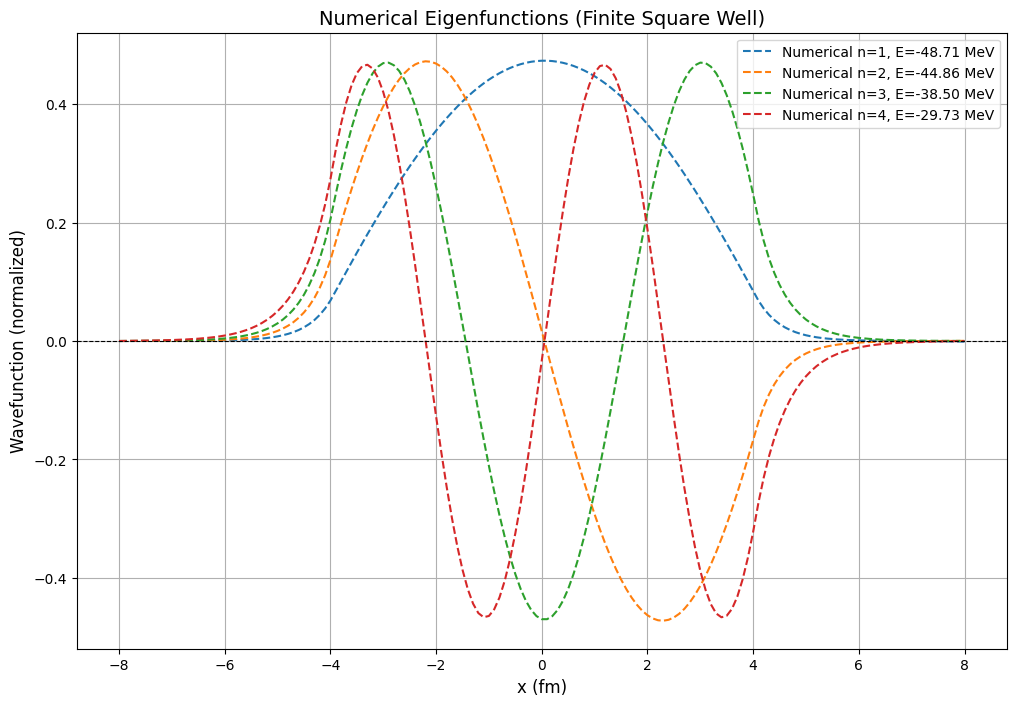

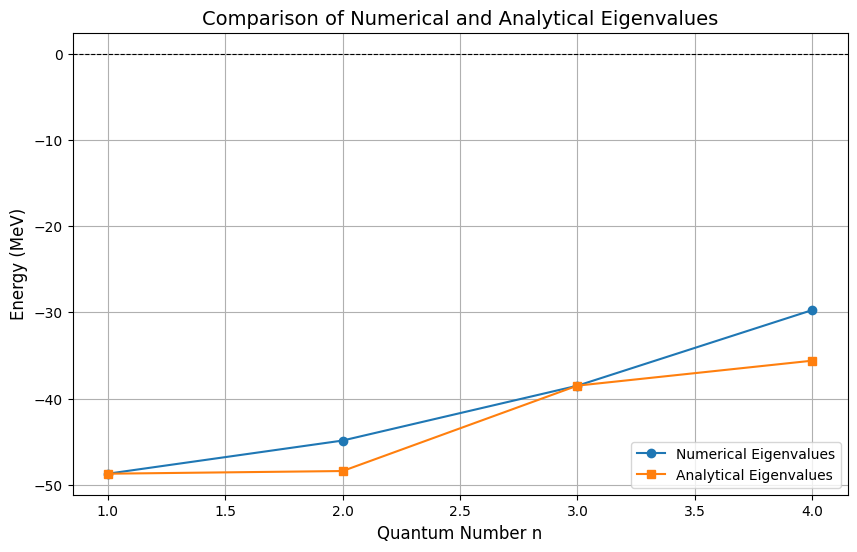

In [ ]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Constants and parameters
hbar2_over_2m = 20.75  # MeV·fm²
a = 4.0  # fm (well width extends from -a to +a)
h = 0.1  # fm (mesh size)
V0 = 50.0  # MeV (depth of the square well)
tolerance = 1e-6  # Energy convergence criterion

# Define the finite square well potential
def V(x):
    return -V0 if abs(x) <= a else 0.0

# Numerov function
def numerov(E, x_grid):
    """Numerov method for propagating the wavefunction."""
    N = len(x_grid)
    psi = np.zeros(N)  # Wavefunction array
    k = 2 * (E - np.array([V(x) for x in x_grid])) / hbar2_over_2m  # k(x) = 2(E - V)/hbar²

    # Initial conditions (ψ(0) = 0, small arbitrary ψ(h))
    psi[0] = 0.0
    psi[1] = 1e-5  # Small arbitrary value

    # Numerov method
    for i in range(1, N - 1):
        psi[i + 1] = (
            (2 * (1 - (5 / 12) * h**2 * k[i]) * psi[i]
             - (1 + (1 / 12) * h**2 * k[i - 1]) * psi[i - 1])
            / (1 + (1 / 12) * h**2 * k[i + 1])
        )

    return psi

# Shooting method to find eigenvalues
def shooting_method(n_nodes, x_grid):
    """Find the eigenvalue for a given number of nodes using the shooting method."""
    E_low, E_high = -V0, 0.0  # Energy range to search
    psi = None

    while E_high - E_low > tolerance:
        E_mid = (E_low + E_high) / 2
        psi = numerov(E_mid, x_grid)

        # Count the number of nodes
        nodes = np.sum(psi[:-1] * psi[1:] < 0)

        # Adjust the energy bounds
        if nodes > n_nodes:
            E_high = E_mid
        else:
            E_low = E_mid

    return E_mid, psi

# Functions defining transcendental equations
def even_solution(E):
    """Equation for even-parity solutions."""
    k = np.sqrt(2 * (E + V0) / hbar2_over_2m)  # Inside the well
    q = np.sqrt(2 * (-E) / hbar2_over_2m)  # Outside the well
    return k * np.tan(k * a) - q

def odd_solution(E):
    """Equation for odd-parity solutions."""
    k = np.sqrt(2 * (E + V0) / hbar2_over_2m)  # Inside the well
    q = np.sqrt(2 * (-E) / hbar2_over_2m)  # Outside the well
    return k / np.tan(k * a) + q

def solve_transcendental(eq_func, E_start, E_end):
    """Find an eigenvalue in a given energy range."""
    solution = root_scalar(eq_func, bracket=[E_start, E_end], method='brentq')
    if solution.converged:
        return solution.root
    else:
        return None

# Analytical eigenvalues
def get_analytical_eigenvalues():
    eigenvalues = []
    energy_range = np.linspace(-V0, 0, 1000)  # Search within [-V0, 0]
    for eq_func in [even_solution, odd_solution] * 2:  # Alternate even/odd solutions
        for i in range(len(energy_range) - 1):
            E1, E2 = energy_range[i], energy_range[i + 1]
            if eq_func(E1) * eq_func(E2) < 0:  # Root detected
                eigenvalue = solve_transcendental(eq_func, E1, E2)
                if eigenvalue is not None:
                    eigenvalues.append(eigenvalue)
                    if len(eigenvalues) == 4:  # Stop after finding 4 eigenvalues
                        break
        if len(eigenvalues) == 4:
            break
    return eigenvalues

# Set up the spatial grid
x_grid = np.arange(-2 * a, 2 * a + h, h)

# Numerical eigenvalues and wavefunctions
numerical_eigenvalues = []
numerical_wavefunctions = []
for n_nodes in range(4):
    E, psi = shooting_method(n_nodes, x_grid)
    numerical_eigenvalues.append(E)
    # Normalize the wavefunction using the grid spacing
    norm = np.sqrt(np.sum(psi**2) * h)
    numerical_wavefunctions.append(psi / norm)

# Analytical eigenvalues
analytical_eigenvalues = get_analytical_eigenvalues()

# Print results
print("Comparison of Eigenvalues (MeV):")
print(f"{'n':<5}{'Numerical':<15}{'Analytical':<15}{'Difference':<15}")
for n, (num, ana) in enumerate(zip(numerical_eigenvalues, analytical_eigenvalues), start=1):
    diff = abs(num - ana)
    print(f"{n:<5}{num:<15.6f}{ana:<15.6f}{diff:<15.6f}")

# Plot the eigenfunctions
plt.figure(figsize=(12, 8))
for i, psi in enumerate(numerical_wavefunctions):
    plt.plot(x_grid, psi, '--', label=f'Numerical n={i+1}, E={numerical_eigenvalues[i]:.2f} MeV')
plt.title('Numerical Eigenfunctions (Finite Square Well)', fontsize=14)
plt.xlabel('x (fm)', fontsize=12)
plt.ylabel('Wavefunction (normalized)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid()
plt.show()

# Plot the eigenvalue comparison
plt.figure(figsize=(10, 6))
n_values = range(1, 5)
plt.plot(n_values, numerical_eigenvalues, 'o-', label='Numerical Eigenvalues')
plt.plot(n_values, analytical_eigenvalues, 's-', label='Analytical Eigenvalues')
plt.title('Comparison of Numerical and Analytical Eigenvalues', fontsize=14)
plt.xlabel('Quantum Number n', fontsize=12)
plt.ylabel('Energy (MeV)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid()
plt.show()
